# Webscraping: Topic extraction

In this exercice, we will get the keywords of the most recent articles of the marketwatch.com on a specific search term

### 1. Importing the necessary packages

In [10]:
import requests
from bs4 import BeautifulSoup
from newspaper import Article, nlp

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

### 2. Defining the search term and the search url

In [11]:
SEARCH_TERM = "amazon"
SEARCH_URL = f"https://www.marketwatch.com/search?q={SEARCH_TERM}&Link=MW_SearchAC&mp=806"
print(SEARCH_URL)

https://www.marketwatch.com/search?q=amazon&Link=MW_SearchAC&mp=806


### 3. Getting the webpage and extracting the links

In [12]:
headers = {"user-agent": "Chrome/84.0.4147"}
result = requests.get(SEARCH_URL, headers=headers)

In [13]:
html_soup = BeautifulSoup(result.text)

In [14]:
# if you use chrome devtools, you can see that the hyperlinks we want are in 
#elements with class "content-list"
elements = html_soup.find_all(attrs={"class": "searchresult"})
articles_urls = []
for element in elements:
    articles_urls.append(element.find("a").get("href"))



### 4. Use newspaper to extract the keywords

In [23]:
%%time
keywords = []
articles = []

# because we call a function from the nlp package of newspaper directly, 
#we first need to manually load the stopwords
nlp.load_stopwords("en")

for article_url in articles_urls:
    # Note: marketwatch sometimes doesnt provide the beginning of the link!
    if article_url.startswith("http://www.marketwatch.com"):
        article = Article(article_url)
    else:
        article = Article("http://www.marketwatch.com" + article_url)
        
    article.download()
    article.parse()
    
    if article.text != "":  # if newspaper doesn't find the text, it gives an empty text
        # calling it directly like this allows us to get the scores of the keywords too
        keywords.append(nlp.keywords(article.text))
        
        # always keep the article in case you need it afterwards -> 
        #this way you don't need to download it again
        articles.append(article)

CPU times: user 3.77 s, sys: 87.8 ms, total: 3.85 s
Wall time: 13.7 s


Now we need to combine the keywords off all articles and sort them by their score

In [16]:
keywords_combined = dict()
for keywords_article in keywords:
    for keyword in keywords_article:
        if keyword in keywords_combined.keys():
            keywords_combined[keyword] += keywords_article[keyword]
        else:
            keywords_combined[keyword] = keywords_article[keyword]

In [17]:
sorting_keywords = sorted([(key, value) for key, value in keywords_combined.items()], key=lambda x: x[1], reverse=True)

In [18]:
sorting_keywords[:20]

[('amazon', 4.094900824107006),
 ('stocks', 4.077891190988321),
 ('stock', 4.049414075685894),
 ('sp', 3.102511826192406),
 ('products', 2.0417910447761196),
 ('service', 2.038288985148515),
 ('product', 2.036194029850746),
 ('500', 2.034371456857791),
 ('index', 2.03171970318375),
 ('walmart', 2.0293580168441125),
 ('market', 2.0250061020258725),
 ('value', 2.020744680851064),
 ('superheroes', 1.046875),
 ('meat', 1.0375),
 ('halo', 1.0371287128712872),
 ('firms', 1.0323212536728696),
 ('volatility', 1.0319148936170213),
 ('territory', 1.0319148936170213),
 ('spiked', 1.0319148936170213),
 ('sixmonth', 1.0319148936170213)]

### 5. A little extra: using Wordcloud

In [19]:
all_text = " ".join([article.text for article in articles])

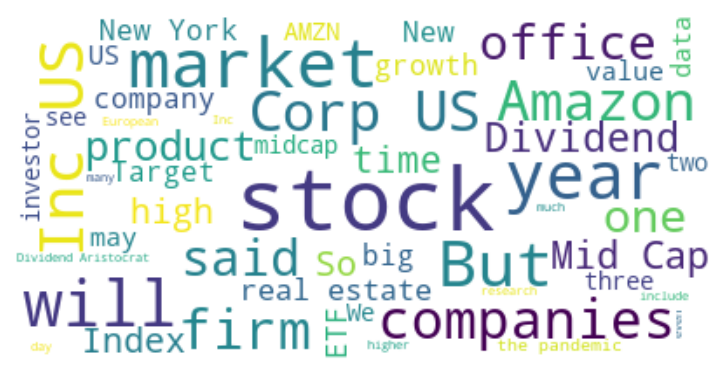

In [20]:
wordcloud = WordCloud(stopwords=STOPWORDS, max_font_size=50, max_words=50, background_color="white").generate(all_text)
fig, ax = plt.subplots(dpi=150)
ax.imshow(wordcloud, interpolation="bilinear")
ax.axis("off")
plt.show()

We can also create it using our keywords from newspaper:

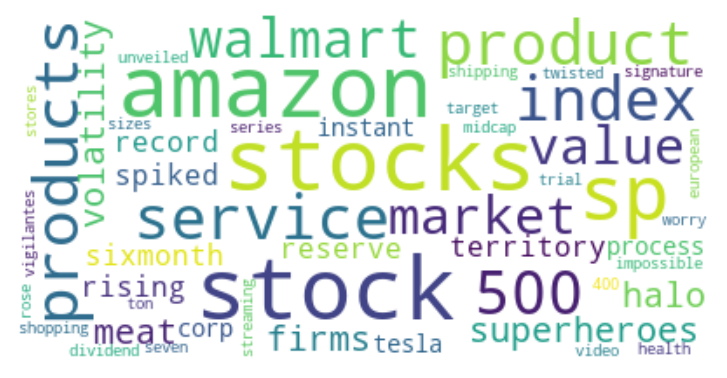

In [21]:
highest_keywords = dict(sorting_keywords)
    
wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white").fit_words(highest_keywords)
wordcloud.words_ = highest_keywords
fig, ax = plt.subplots(dpi=150)
ax.imshow(wordcloud, interpolation="bilinear")
ax.axis("off")
plt.show()